In [1]:
import pandas as pd
import numpy as np

papers = pd.read_csv('pubmed_causal_language_use.csv')

print(papers.sentence.head(5).values)
papers.head(3)

['Levels of cholesterol fractions in patients with JIA were found within the normal range.'
 'Faster aspart and IAsp were confirmed noninferior in a basal-bolus regimen regarding change from baseline in HbA1c.'
 'Major operative morbidity after minimally invasive hysterectomy is rare regardless of the surgical approach.'
 'The promise of combining risk assessment, communication and management within one consultation was not realised.'
 'PPARÎ´ peroxisome proliferator-activated receptor Î´, STAT3 signal transducer and activator of transcription 3, CTGF connective tissue growth factor, MMP9 matrix metallopeptidase 9."']


,sentence,label
0,Levels of cholesterol fractions in patients wi...,0
1,Faster aspart and IAsp were confirmed noninfer...,0
2,Major operative morbidity after minimally inva...,0


# Data Exploration

In [2]:
# Which Vectorization Method?

# compute and summarize length of each sentence
sentence_array = papers.sentence.values

len_finder = np.vectorize(len)

lengths = len_finder(sentence_array)

lengths_df = pd.DataFrame(lengths)

print(lengths_df.describe()) # since there is a relatively large standard deviation of character lengths, tfidf would help normalize weights of tokens

                 0
count  3061.000000
mean    131.129696
std      53.468980
min      21.000000
25%      93.000000
50%     124.000000
75%     163.000000
max     372.000000


In [3]:
# Data-split or Cross Validation?

# Count for each label
paper_groups = papers.groupby(by=['label']).size().sort_values(ascending=False)

# Count all documents
num_papers = papers.shape[0]

# proportion of labels
paper_groups = paper_groups/num_papers

print('total number of documents: ', num_papers)
print('\nlabel proportions:\n', paper_groups)

# since there are only ~3k documents and labels are skewed, cross-validation of K=5 will be used to train/test models

total number of documents:  3061

label proportions:
 label
0    0.442992
3    0.326037
1    0.161385
2    0.069585
dtype: float64


# Data Split

In [4]:
# Split test and train

import sklearn
from sklearn.model_selection import train_test_split

x_ = papers.sentence.values
y_ = papers.label.values

x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=(1/5), random_state=0)


# Vectorization

In [5]:
# vectorize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tfidf_1g_vec  = TfidfVectorizer(stop_words='english')
tfidf_12g_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))

count_1g_vec  = CountVectorizer(stop_words='english')
count_12g_vec = CountVectorizer(stop_words='english', ngram_range=(1,2))

vecs = [tfidf_1g_vec,tfidf_12g_vec,count_1g_vec,count_12g_vec]

vecs_fit = [i.fit(x_train, y_train) for i in vecs]

# Make Pipelines

In [6]:
# Build Pipes

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV

mnb = MultinomialNB()
svc = LinearSVC()
tfidf = TfidfVectorizer()
count = CountVectorizer()


mnb_tfidf_pipe = Pipeline([('vec_tfidf', tfidf), ('model_mnb', mnb)])

mnb_count_pipe = Pipeline([('vec_count', count), ('model_mnb', mnb)])

svc_tfidf_pipe = Pipeline([('vec_tfidf', tfidf),('model_svc', svc)])

svc_count_pipe = Pipeline([('vec_count', count),('model_svc', svc)])

In [75]:
# generate search grid parameters

tfidf_params = dict(
    vec_tfidf__encoding=['latin-1'],
    vec_tfidf__stop_words=['english',None],
    vec_tfidf__ngram_range=[(1,1),(1,2),(1,3)],
    vec_tfidf__max_df=[.55,.6,.65],
    vec_tfidf__min_df=[1],
    vec_tfidf__norm=['l1','l2'])

count_params = dict(
    vec_count__encoding=['latin-1'],
    vec_count__stop_words=['english', None],
    vec_count__ngram_range=[(1,1),(1,2),(1,3)],
    vec_count__max_df=[.55,.6,.65],
    vec_count__min_df=[1])

mnb_params = dict(
    model_mnb__alpha=[.8,.9,1])

svc_params = dict(
    model_svc__C=[.7,.8])

In [76]:
# Assign Search Grid params

from sklearn.model_selection import GridSearchCV

# tfidf and MNB
tfidf_mnb_params = {**tfidf_params, **mnb_params}
tfidf_mnb_grid = GridSearchCV(mnb_tfidf_pipe, tfidf_mnb_params, cv=5, n_jobs=-1)

# count and MNB
count_mnb_params = {**count_params, **mnb_params}
count_mnb_grid = GridSearchCV(mnb_count_pipe, count_mnb_params, cv=5, n_jobs=-1)

# tfidf and SVC
tfidf_svc_params = {**tfidf_params, **svc_params}
tfidf_svc_grid = GridSearchCV(svc_tfidf_pipe, tfidf_svc_params, cv=5, n_jobs=-1)

# count and SVC
count_svc_params = {**count_params, **svc_params}
count_svc_grid = GridSearchCV(svc_count_pipe, count_svc_params, cv=5, n_jobs=-1)


# Fit Models

In [77]:
# fit models

tfidf_mnb_grid.fit(x_train, y_train)
count_mnb_grid.fit(x_train, y_train)
tfidf_svc_grid.fit(x_train, y_train)
count_svc_grid.fit(x_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec_count', CountVectorizer()),
                                       ('model_svc', LinearSVC())]),
             n_jobs=-1,
             param_grid={'model_svc__C': [0.7, 0.8],
                         'vec_count__encoding': ['latin-1'],
                         'vec_count__max_df': [0.55, 0.6, 0.65],
                         'vec_count__min_df': [1],
                         'vec_count__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'vec_count__stop_words': ['english', None]})

# Find best scoring vectorization method/model

In [145]:
# compare results

print(tfidf_mnb_grid.best_score_)

print(count_mnb_grid.best_score_)

print(tfidf_svc_grid.best_score_)

print(count_svc_grid.best_score_)

# observing the best params, we can reassign the grid so that each best param value is in the middle of the range,
# then fit again. Once the accuracy increase delta goes under 1, we can stop.

print('\nParameters of the best model:\n',tfidf_svc_grid.best_params_)



0.6715687992988606
0.7087425399607696
0.7614356662910564
0.7577571887650766

Parameters of the best model:
 {'model_svc__C': 0.8, 'vec_tfidf__encoding': 'latin-1', 'vec_tfidf__max_df': 0.55, 'vec_tfidf__min_df': 1, 'vec_tfidf__ngram_range': (1, 2), 'vec_tfidf__norm': 'l2', 'vec_tfidf__stop_words': None}

Parameters of the best model:
 {'model_mnb__alpha': 0.8, 'vec_count__encoding': 'latin-1', 'vec_count__max_df': 0.55, 'vec_count__min_df': 1, 'vec_count__ngram_range': (1, 2), 'vec_count__stop_words': None}


# Feature Ranking

In [84]:
# Top 10 features for each category in SVM

# extract features and coefficients
coeffs_ = tfidf_svc_grid.best_estimator_.named_steps['model_svc'].coef_
vocab_  = tfidf_svc_grid.best_estimator_.named_steps['vec_tfidf'].get_feature_names_out()

# init dataframe
coef_df = pd.DataFrame(
    index=vocab_
)

# assign coefficients to each category
coef_df['0_NoRelation'] = coeffs_[0]
coef_df['1_Direct'] = coeffs_[1]
coef_df['2_Conditional'] = coeffs_[2]
coef_df['3_Correlation'] = coeffs_[3]

# print out top 10 features for each category

top_noRelation       = coef_df['0_NoRelation'].sort_values(ascending=False).head(20).index.tolist()
top_direct           = coef_df['1_Direct'].sort_values(ascending=False).head(20).index.tolist()
top_conditional      = coef_df['2_Conditional'].sort_values(ascending=False).head(20).index.tolist()
top_correlational    = coef_df['3_Correlation'].sort_values(ascending=False).head(20).index.tolist()


print('Top 10 no relation words:\n',top_noRelation)
print('\nTop 10 direct causal words:\n',top_direct)
print('\nTop 10 conditional causal words:\n',top_conditional)
print('\nTop 10 correlation words:\n',top_correlational)


Top 10 no relation words:
 ['should', 'studies', 'needed', 'need', 'further', 'should be', 'research', 'future', 'safety', 'required', 'study', 'can be', 'appropriate', 'larger', 'trial', 'trials', 'screening', 'be', 'assessment', 'needed to']

Top 10 direct causal words:
 ['improved', 'effective', 'resulted in', 'resulted', 'effect', 'improves', 'effects', 'did', 'did not', 'benefit', 'can', 'reduced', 'reducing', 'increased the', 'that', 'benefits', 'affected', 'significantly', 'oral', 'impact']

Top 10 conditional causal words:
 ['may', 'could', 'might', 'may have', 'may improve', 'improve', 'reduce', 'role in', 'may increase', 'may reduce', 'the risk', 'role', 'play', 'appear', 'effective', 'increase', 'appear to', 'play role', 'likely', 'to influence']

Top 10 correlation words:
 ['associated', 'associated with', 'related to', 'with', 'predict', 'between', 'related', 'association', 'increased', 'were', 'predictor', 'was', 'higher', 'risk', 'risk factor', 'lower', 'is associated', 

# Performance

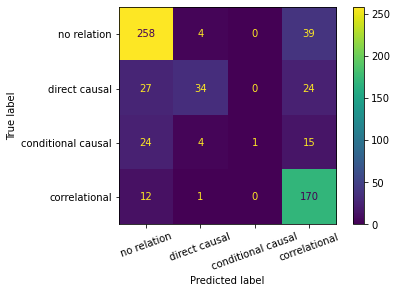

In [118]:
# confusion matrix of MNB

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib as plt

y_pred_mnb = count_mnb_grid.predict(x_test)
cm_mnb = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test, 
    y_pred=y_pred_mnb, 
    display_labels=['no relation','direct causal','conditional causal','correlational'], 
    xticks_rotation=20
)

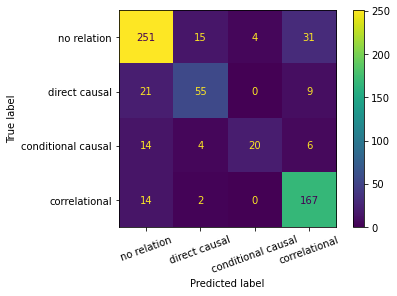

In [120]:
# Confusion Matrix of SVM

y_pred_svc = tfidf_svc_grid.predict(x_test)

cm_svc = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test, 
    y_pred=y_pred_svc, 
    display_labels=['no relation','direct causal','conditional causal','correlational'], 
    xticks_rotation=20
)

In [135]:
# Compute precision, recall, F1

from sklearn.metrics import precision_score, recall_score, f1_score

# MNB
precision_mnb = precision_score(y_test, y_pred_mnb, average=None) # micro average since it Calculate metrics globally by counting the total true positives, false negatives and false positives.
recall_mnb = recall_score(y_test, y_pred_mnb, average=None)
f1_mnb = f1_score(y_test, y_pred_mnb, average=None)

print(
    'MNB',
    '\nprecision: ', precision_mnb,
    '\nrecall: ', recall_mnb,
    '\nF1-Measure: ',f1_mnb
)

# SVC
precision_svc = precision_score(y_test, y_pred_svc, average=None) 
recall_svc = recall_score(y_test, y_pred_svc, average=None)
f1_svc = f1_score(y_test, y_pred_svc, average=None)

print(
    '\n\nSVC',
    '\nprecision: ', precision_svc,
    '\nrecall: ', recall_svc,
    '\nF1-Measure: ',f1_svc
)

MNB 
precision:  [0.80373832 0.79069767 1.         0.68548387] 
recall:  [0.85714286 0.4        0.02272727 0.92896175] 
F1-Measure:  [0.82958199 0.53125    0.04444444 0.78886311]


SVC 
precision:  [0.83666667 0.72368421 0.83333333 0.78403756] 
recall:  [0.83388704 0.64705882 0.45454545 0.91256831] 
F1-Measure:  [0.83527454 0.68322981 0.58823529 0.84343434]


# Error Analysis

In [144]:
# Analyze top mislabeled value

# MNB
no_relation_predicted_correlation_mnb = []

for i, pred in enumerate(y_pred_mnb):
    if (pred == 3) and (y_test[i] == 0):
        no_relation_predicted_correlation_mnb.append(x_test[i])

print(len(no_relation_predicted_correlation_mnb))


# SVC
no_relation_predicted_correlation_svc = []

for i, pred in enumerate(y_pred_svc):
    if (pred == 3) and (y_test[i] == 0):
        no_relation_predicted_correlation_svc.append(x_test[i])

print(len(no_relation_predicted_correlation_svc))


# Print some of the results
print(
    '\nMNB\n',no_relation_predicted_correlation_mnb[:5], 
    '\n\n',
    'SVC\n',no_relation_predicted_correlation_svc[:5]
)

39
31

MNB
 ['Our study confirms the well-known negative metabolic changes in PCOS patients.', 'Among individuals with a history of SAMS, most will tolerate statin  therapy.', 'Fibroadenomas and phyllodes tumours differ with regard to various cytological features, aiding in their distinction on fine-needle aspiration biopsy.', 'Seemingly, obvious reasons could not be retained as valid explanations.', 'Although conventional echocardiography revealed no difference between patients with type 1 DM and healthy children, TDE showed dysfunctions of  both ventricles.'] 

 SVC
 ['Whereas kitchen and nursing-related aspects of nutritional care seem  to be widely implemented in German NHs, management and quality assurance demands  are often not met.', 'Our study confirms the well-known negative metabolic changes in PCOS patients.', 'The new onset GERD detected on scintigraphy may not be pathologic as there is a decrease in total acid production postsurgery; however, it still remains an important 